# Задание №2: Фрактальное сжатие

ФИО: Иван Иванович Иванов  
Группа: 200

**Баллы за задание выставляются исходя из качества алгоритма по итограм сравнения всех решений**

## Правила сдачи
* Для сдачи необходимо в [cv-gml](https://fall.cv-gml.ru/) загрузить Jupyter-ноутбук с выполненным заданием
* В некоторых ячейках есть строки (`# GRADED CELL: [function name]`), эти строки **менять нельзя**, они будет использоваться при проверке вашего решения
* Интерфейс функций и классов помеченных таким образом должен остаться без изменений
* Ячейка со строкой (`# GRADED CELL: [function name]`) должна содержать только **одну функцию или класс**
 * Лайфхак: функции можно определять внутри функций
* Никакие другие ячейки не будут использованы при проверке, они должны быть самодостаточны
* Запрещено импортировать иные библиотеки и функции, кроме указанных в первой ячейке с кодом  
(если сильно захочется что-то еще импортировать, спросите в чате курса)

## Немного теории
Алгоритм описан в главе про [сжатие изображений](https://compression.ru/book/part2/part2__3.htm#_Toc448152512).

### Определения
**Ранговый блок**: если исходное изображение разбивается на непересекающиеся блоки одинакового размера, замощающие всё изображение, то каждый такой блок называется *ранговым*; имеют меньший размер, чем доменные блоки.

**Доменный блок**: если исходное изображение разбивается блоки одинакового размера, которые могут и пересекаться, то каждый такой блок называется *доменным*; имеют больший размер, чем ранговые блоки.

**Идея алгоритма**:

При сжатии:
1. для каждого рангового блока найти наиболее похожий на него доменный блок (с учётом поворотов и симметрии)
2. выполнить преобразование яркости
3. в качестве сжатого изображения выступают коэффициенты преобразования ранговых блоков, эффективно записанные в файл (строку)

При декомпрессии:
1. Прочитать файл (строку), извлечь коэффициенты преобразований
2. Применить преобразования к исходному изображению (обычно просто серое) пока результат не стабилизируется

In [4]:
# Standard Python Library

import os
import itertools

import struct # i added this library to work with binary data

from collections import namedtuple

# Additional Modules

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv, yuv2rgb

from tqdm import tqdm

import tests

Первым делом нужно загрузить картинку

In [5]:
lenna_rgb_512x512 = io.imread('test_files/lenna.bmp')
lenna_rgb_256x256 = np.rint(resize(lenna_rgb_512x512, (256, 256)) * 255).astype('uint8')
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype('uint8')
lenna_gray_128x128 = np.rint(resize(lenna_gray_256x256, (128, 128)) * 255).astype('uint8')

`plt` — модуль для рисования графиков и всего остального

Очень удобная штука, будем пользоваться ей довольно часто

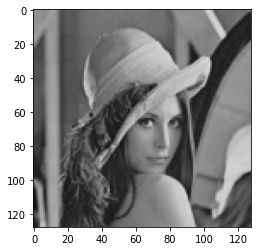

In [3]:
plt.imshow(lenna_gray_128x128, cmap='gray', vmin = 0, vmax = 255)

## Общие функции
В следующих клетках описаны функции и классы, которые будут использоваться **вами** при выполнении следующих подзаданий. Стоит с ними подробно ознакомиться, понять, что они делают, и поэкспериментировать.

Вы можете свободно эксперементировать с форматом BlockTransform и FractalCompressionParams при необходимости

In [95]:
# GRADED CELL: BlockTransform

BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'col', 'tr', 'mse', 'size'])
ColorChange = namedtuple('ColorChange', ['p', 'r'])

#### BlockTransform

Трансформация, которая приближает данный ранговый блок

* `x, y` Координаты выбранного доменного блока
* `di` Цветовое смещение
* `tr` Закодированное преобразование (поврот и смещение)

In [157]:
# GRADED CELL: FractalCompressionParams

FractalCompressionParams = namedtuple(
    'FractalCompressionParams', [
        'height',
        'width',
        'is_colored',
        'block_size',
#         'spatial_scale',
#         'intensity_scale',
        'stride'
    ]
)

In [6]:
def derive_num_bits(length, stride):
    return np.ceil(np.log2(length / stride)).astype(int)

In [161]:
def is_colored(image):
    if len(image.shape) == 2:
        return False
    elif len(image.shape) == 3 and image.shape[-1] == 3:
        return True
    else:
        message = 'Invalid shape of the image: `{}`'
        raise ValueError(message.format(image.shape))
        
def resize_image(image):
    return np.rint(resize(image, (image.shape[0] // 2, image.shape[1] // 2))).astype('uint8')

### Функция для нахождения наилучшего преобразования рангового блока

#### Описание

на входе функции подаются:
* исходное Ч/Б изображение (`image`)
* уменьшенное изображение (`resized_image`)
* координаты рангового блока (`x`, `y`)
* размер блока (`block_size`)
* шаг, через сколько пикселей перескакивать при переборе (`stride`)

на выходе функция должна выдавать:
* лучшее преобразование в смысле MSE, объект типа `BlockTransform`

#### Примечания по использованию resized_image

Доменный блок больше рангового, поэтому для сопоставления его нужно уменьшить. Но операция уменьшения дорогая при применении к каждому блоку, поэтому можно сразу уменьшить все изображение целиком и выбирать доменные блоки оттуда.

In [96]:
# GRADED CELL: find_block_transform

def find_block_transform(image, resized_image, x, y, block_size, stride, to_print = False):
    '''Find best transformation for given rank block.

    Parameters
    ----------
    image : np.array
        Source B/W image.

    resized_image: np.array
        Resized source image.

    x, y: int, int
        Coordinates of the rank block.

    block_size: int
        Size of rank block.

    stride: int
        Vertical and horizontal stride for domain block search.

    Returns
    -------
    best_transform: BlockTransform
        Best transformation.
    '''
    
    def find_contrast_params(R, D): 
        p = 0.75
        X = R - D
        r = int(np.sum(X) / R.size)
        MSE = np.sum((X - r) ** 2)
        return p, r, MSE

    def trans(X, i):
        for j in range(i % 4):
            X = np.rot90(X)
        if (i >= 4):
            X = X.T
        return X

    resized_image = resized_image * 0.75
    trans_im = [trans(resized_image, i) for i in range(8)]
        
    R = image[x:x+block_size, y:y+block_size]
    size = image.shape[0]
    best_t = None
    best_MSE = 10000000000000
    for xx, yy in itertools.product(range(0, size // 2 - block_size, stride), range(0, size // 2 - block_size, stride)):
        for i in range(8):
            D = trans_im[i][xx:xx+block_size, yy:yy+block_size]  
            p, r, MSE = find_contrast_params(R, D)
            if MSE < best_MSE:
                best_MSE = MSE
                best_t = BlockTransform(xx, yy, ColorChange(p, r), i, MSE, block_size)

    if to_print == True:
        plt.figure(figsize = (15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)
        
        plt.subplot(1, 3, 2)
        plt.imshow(R, cmap = 'gray', vmin = 0, vmax = 255)
                
        t = best_t
        xx = t.x; yy = t.y; p = t.col.p; r = t.col.r
        # coords on source image
        D = trans_im[t.tr][xx:xx+block_size, yy:yy+block_size]  
        X = D + r
        plt.subplot(1, 3, 3)
        plt.imshow(X, cmap = 'gray', vmin = 0, vmax = 255)
    return best_t

### Протестируем функцию на простых примерах

BlockTransform(x=0, y=0, col=ColorChange(p=0.75, r=35), tr=2, mse=100585.9375)


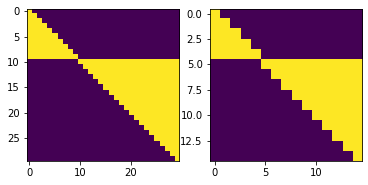

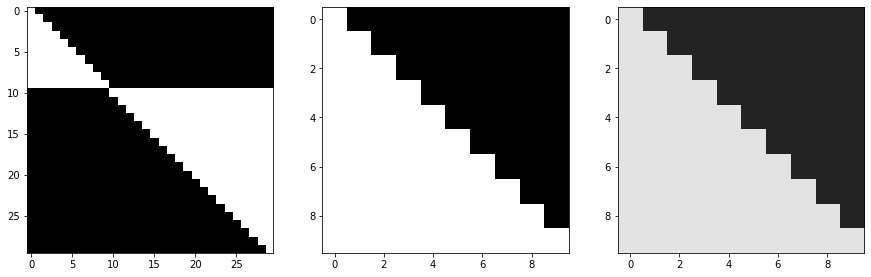

In [9]:
a = np.zeros((30, 30), dtype = float)
a[0:10, 0:10] = np.tril(np.ones((10, 10)), 0)
a[10:30, 10:30] = np.tril(np.ones((20, 20)), 0).T
b = resize_image(a)
a *= 255; b *= 255

plt.subplot(1, 2, 1)
plt.imshow(a)
plt.subplot(1, 2, 2)
plt.imshow(b)

t1 = find_block_transform(a, b, 0, 0, 10, 1, True)
print(t1)

BlockTransform(x=0, y=4, col=ColorChange(p=0.75, r=67), tr=7, mse=429162.0625)


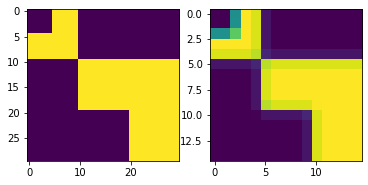

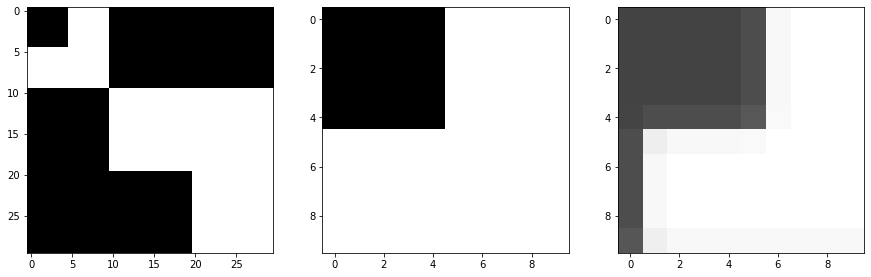

In [10]:
a = np.zeros((30, 30), dtype = float)
a[0:10, 0:10] = np.ones((10, 10))
a[0:5, 0:5] = np.zeros((5, 5))
a[10:30, 10:30] = np.ones((20, 20))
a[20:30, 10:20] = np.zeros((10, 10))

a*=255
b = resize_image(a)

plt.subplot(1, 2, 1)
plt.imshow(a)
plt.subplot(1, 2, 2)
plt.imshow(b)

t1 = find_block_transform(a, b, 0, 0, 10, 1, True)
print(t1)

BlockTransform(x=20, y=10, col=ColorChange(p=0.75, r=17), tr=5, mse=3163030.125)


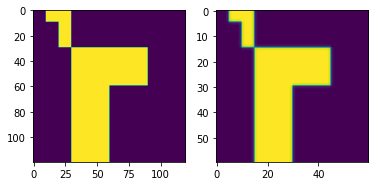

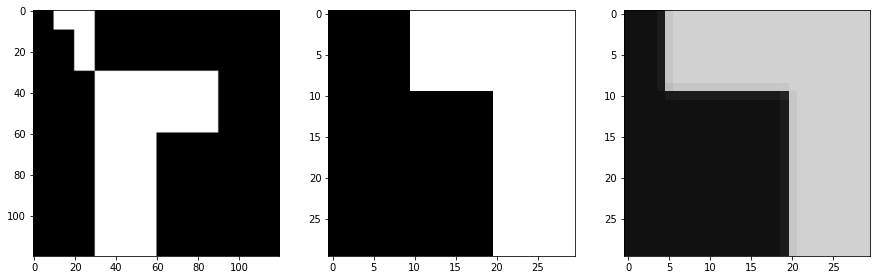

In [11]:
a = np.zeros((120, 120), dtype = float)
a[0:10, 10:30] = np.ones((10, 20))
a[10:30, 20:30] = np.ones((20, 10))
a[30:60, 30:90] = np.ones((30, 60))
a[60:120, 30:60] = np.ones((60, 30))

a*=255
b = resize_image(a)

plt.subplot(1, 2, 1)
plt.imshow(a)
plt.subplot(1, 2, 2)
plt.imshow(b)

t1 = find_block_transform(a, b, 0, 0, 30, 1, True)
print(t1)

### Применение IFS к изображению

#### Описание

на входе функции подаются:
* исходное изображение (`image`)
* уменьшенное изображение (`resized_image`)
* IFS, массив объектов типа `BlockTransform` (`transforms`)
* размер блока (`block_size`)

на выходе функция должна выдавать:
* картинку после одинарного применения IFS

In [118]:
# GRADED CELL: perform_transform

def perform_transform(image, resized_image, transforms, block_size):
    '''Perform IFS on given image.

    Parameters
    ----------
    image : np.array
        Source image.

    resized_image: np.array
        Resized source image.

    transforms: list of BlockTransform's
        Given IFS, Iterated Function System

    block_size: int
        Size of rank block.

    Returns
    -------
    transformed_image: np.array
        Transformed image.
    '''

    # YOUR CODE HERE
    def trans(X, i):
        for j in range(i % 4):
            X = np.rot90(X)
        if (i >= 4):
            X = X.T
        return X

    class Reader:
        def __init__(self, t):
            self.pos = 0
            self.body = t
        def read(self):
            ret = self.body[self.pos]
            self.pos += 1
            return ret

    def decode_block(x, y, block_size):
        elem = rdr.read()
        if elem != 'split':
            xx = elem.x; yy = elem.y; p = elem.col.p; r = elem.col.r # coords on source image
            D = trans_im[elem.tr][xx:xx + block_size, yy:yy+block_size] * p
            X = D + r
            transformed_image[x:x+block_size, y:y+block_size] = X
        else:
            block_size //= 2
            decode_block(x, y, block_size)
            decode_block(x + block_size, y, block_size)
            decode_block(x, y + block_size, block_size)
            decode_block(x + block_size, y + block_size, block_size)

    image_size = image.shape[0]
    # resized_image = resized_image * 0.75
    transformed_image = np.zeros(image.shape)
    rdr = Reader(transforms)

    trans_im = [trans(resized_image, i) for i in range(8)]
    coordinates = itertools.product(range(0, image_size, block_size), range(0, image_size, block_size))
    for x, y in coordinates:
        decode_block(x, y, block_size)
    return transformed_image

## Построим квадродерево

In [154]:
def encode_block(image, resized_image, x, y, block_size, stride, trans):
    t = find_block_transform(image, resized_image, x, y, block_size, stride)
    if t.mse > 120 * (block_size ** 2) and block_size > 2:
        trans.append('split')
        block_size //= 2
        stride //= 2
        encode_block(image, resized_image, x, y, block_size, stride, trans)
        encode_block(image, resized_image, x + block_size, y, block_size, stride, trans)
        encode_block(image, resized_image, x, y + block_size, block_size, stride, trans)
        encode_block(image, resized_image, x + block_size, y + block_size, block_size, stride, trans)
    else:
        trans.append(find_block_transform(image, resized_image, x, y, block_size, stride))

def encode(image, resized_image, block_size, stride):
    trans = []
    for x in tqdm(range(0, image.shape[0], block_size)):
        for y in range(0, image.shape[1], block_size):
            encode_block(image, resized_image, x, y, block_size, stride, trans)
    return trans
        
t = encode(lenna_gray_256x256, lenna_gray_128x128, 16, 32)

100%|██████████| 16/16 [08:01<00:00, 30.09s/it]


In [148]:
vals = [x.mse / (x.size ** 2) for x in t if type(x) != str]
print(vals)
step = 5
r = np.arange(int(min(vals)), int(max(vals)), step)
interv = {(a, a + step) : 0 for a in r}
for x in vals:
    for a in r:
        if a < x <= a + step:
            interv[(a, a + step)] += 1

[13.12890625, 8.037109375, 5.9814453125, 2.45703125, 5.66015625, 32.85546875, 18.45703125, 2.6328125, 2.390625, 12.76953125, 19.69921875, 26.568359375, 9.830078125, 11.4248046875, 4.005859375, 2.822265625, 8.69140625, 9.7109375, 20.921875, 10.009765625, 12.662109375, 5.8876953125, 4.6142578125, 6.490234375, 8.861328125, 19.6640625, 13.37109375, 1.61328125, 9.375, 2.89453125, 1.296875, 4.3984375, 6.9609375, 9.59375, 10.4638671875, 14.22265625, 2.6220703125, 1.3408203125, 29.43359375, 6.65234375, 1.62890625, 36.8359375, 0.921875, 0.75, 20.26171875, 10.1796875, 50.203125, 6.4921875, 8.05078125, 183.1484375, 1.203125, 15.9609375, 139.015625, 2.140625, 9.298828125, 14.69140625, 112.17578125, 3.65625, 2.42578125, 14.06640625, 6.9697265625, 3.453125, 97.59765625, 81.81640625, 17.3515625, 4.46484375, 99.56640625, 176.4609375, 10.8125, 10.9853515625, 3.7392578125, 14.486328125, 13.9267578125, 7.51953125, 27.44921875, 5.171875, 38.5546875, 9.7392578125, 9.95703125, 2.14453125, 2.76171875, 13.105

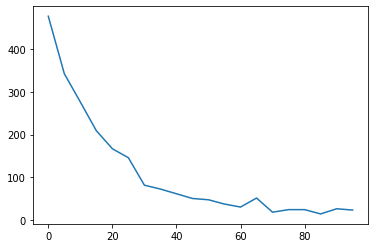

In [151]:
end = 100
limit = int(end // step)
plt.plot(r[:limit], ([*interv.values()][:limit]))
plt.show()

In [129]:
print(len(r))

18340


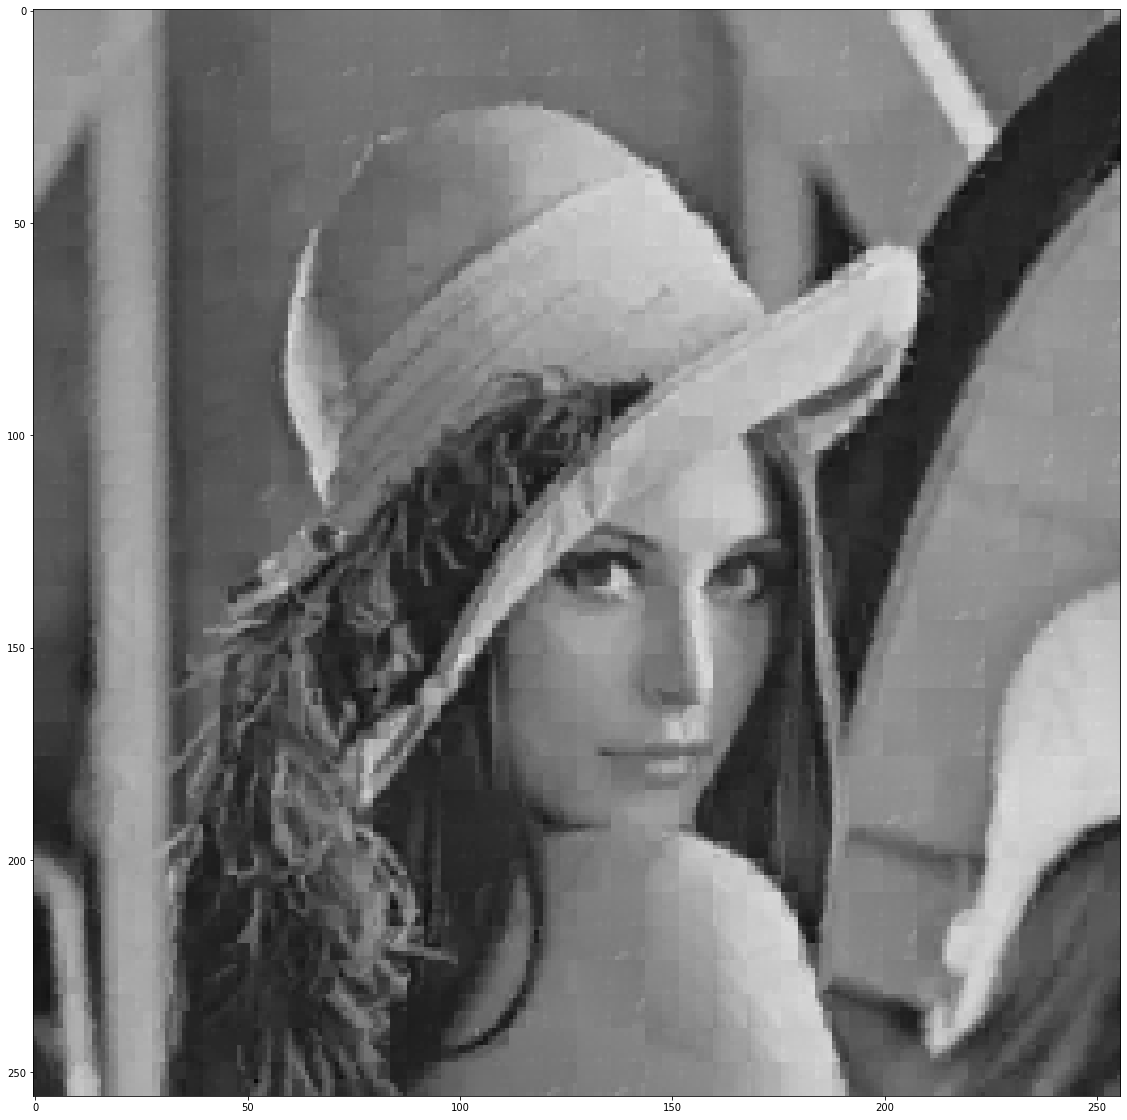

In [120]:
im = np.zeros_like(lenna_gray_256x256)
rim = resize(im, (128, 128))

it = [100]
plt.figure(figsize=(20, 20))

for i in range(len(it)):
    plt.subplot(len(it), 1, i + 1)
    for _ in range(it[i]):
        im = perform_transform(im, rim, t, 16)
        rim = resize(im, (128, 128))
    plt.imshow(im, cmap = 'gray', vmin = 0, vmax = 255)

### Тестирование функций нахождения наилучшего преобразования и применения IFS к изображению

#### Описание

* Эти тесты нужны только для базовой отладки двух функций выше, они не используются при оценке задания
* Тесты проверяют правильность подбора di и возможность использования поворотов и отражений
* Если тесты не проходят, возможно вы реализовали неоптимальный алгоритм поиска преобразований
* Даже с неоптимальным поиском блоков можно успешно сжать и расжать изображение

In [ ]:
# tests.test_transform(find_block_transform, perform_transform)

### Класс, реализующий интерфейс битового массива
Он понадобится для преобразования найденной IFS в строку, чтобы записать сжатый файл на диск.

In [158]:
# GRADED CELL: BitBuffer

class BitBuffer:
    '''Class that provides storing and and reading integer numbers
    in continuous bytearray.

    Parameters
    ----------
    buffer : bytearray, optional (default=None)
        Input bytearray, for initialization.

    Attributes
    ----------
    _buffer : bytearray
        Bytearray that can contain any information.

    Examples
    --------
    >>> buffer = BitBuffer()
    >>> buffer.push(1, 1)
    >>> x = buffer.pop(1)
    >>> print(x)
    1
    >>> buffer.push(125, 18)
    >>> x = buffer.pop(18)
    >>> print(x)
    125
    >>> buffer.push(5, 3)
    >>> x = buffer.pop(3)
    >>> print(x)
    5

    >>> dy = transform.y // stride
    >>> buffer.push(dy, self._num_bits_ver)
    '''

    def __init__(self, buffer=None):
        self.chunk = 8
        if buffer is not None:
            self.from_raw(buffer)
        else:
            self.rescale = 1
            self.pos = 0
            self.size = self.chunk * self.rescale
            self.body = np.zeros(self.rescale, dtype=np.int8)

    def to_bytearray(self):
        '''Convert to bytearray.

        Returns
        -------
        buffer: bytearray
            Bytearray that contains all data.
        '''
        cur_pos = self.pos % 8
        self.push(0, 8 - cur_pos)
        self.push(0, 5)
        self.push(cur_pos, 3)
        return self.body
    
    def from_raw(self, buf):
        self.body = np.copy(buf)
        self.pos = buf.size * self.chunk
        self.size = self.pos
        cur_pos = self.pop(3)
        self.pop(5)
        self.pop(8 - cur_pos)

    def push(self, x, n_bits):
        '''Push given integer to buffer.

        Parameters
        ----------
        x : int
            Input number.

        n_bits: int
            Number of bits for store input number,
            should be greater than log2(x).
        '''

        # YOUR CODE HERE
        while self.pos + n_bits > self.size:
            self.body = np.concatenate((self.body, np.zeros(self.rescale, dtype=np.int8)))
            self.size += self.rescale * self.chunk
        for i in range(self.pos, self.pos + n_bits):
            bit = (x % 2) << (i % self.chunk)
            self.body[i // self.chunk] |= bit
            x >>= 1
        self.pos += n_bits

    def pop(self, n_bits):
        '''Pop n_bits from buffer and transform it to a number.

        Parameters
        ----------
        n_bits: int
            Number of bits for pop from buffer.

        Returns
        -------
        x: int
            Extracted number.
        '''

        # YOUR CODE HERE
        x = 0
        for i in range(self.pos - 1, self.pos - n_bits - 1, -1):
            x <<= 1
            bias = i % self.chunk
            bit = 1 << bias
            x += (self.body[i // self.chunk] & bit) >> bias
            self.body[i // self.chunk] &= ~np.int8(bit)
        self.pos -= n_bits
        return x

In [159]:
b = BitBuffer()
n = 16
b.push(2 ** 20 - 1, n)
bb = b.to_bytearray()
print(bb)

q = BitBuffer(bb)
q.pop(n)


[-1 -1  0  0]


65535

### Тестирование битового массива

#### Описание

* Эти тесты нужны только для базовой отладки класса выше, они не используются при оценке задания
* Тесты проверяют корректность записи и чтения в FIFO либо LIFO формате. Вы можете использовать любой из них

In [ ]:
tests.test_bit_buffer(BitBuffer)

### Класс, реализующий интерфейс архиватора изображений

#### Условие
* Класс будет тестироваться как на черно-белых, так и на **цветных** изображениях
* Для цветных изображений необходимо переходить в YUV, сжимать, а потом обратно в RGB для финального результата
* В качестве оценки алгоритма будет использоваться кривая размер-качество, построенная на основе запуска метода compress2, с параметрами качества [0, 20, 40, 60, 80, 100]
* Следует обеспечить непрерывную монотонную зависимость реального качества декодированного изображения от параметра качества
* Баллы будут выставляться исходя из того, насколько построенный график размер-качество лежит близко к верхнему левому углу (высокое качество и низкий размер)
* За красивые графики с равномерно распределенными узлами [0 ... 100] и без точек перегиба выставляются дополнительные баллы
* Ограничение времени работы (суммарно сжатие и разжатие) на всех уровнях качества: 5 минут

**Интерфейсом данного класса считаются только методы compress2 и decompress, остальные можно менять как угодно**`

In [208]:
# GRADED CELL: FractalCompressor

class FractalCompressor:
    '''Class that performs fractal compression/decompression of images.

    Attributes
    ----------
    _num_bits_ver : int
        Number of bits for store VERTICAL OFFSET for each transformation.
    
    _num_bits_hor : int
        Number of bits for store HORIZONTAL OFFSET for each transformation.
        
    _num_bits_pix : int
        Number of bits for store INTENSITY OFFSET for each transformation.
        
    _num_bits_tfm : int
        Number of bits for store TRANFORMATION INDEX for each transformation.

    Examples
    --------
    >>> comp = FractalCompressor()
    >>> compressed_image = comp.compress(image, block_size=8, stride=2)
    >>> decompressed_image = comp.decompress(compressed_image, num_iters=9)
    >>> yet_another_compressed_image = comp.compress(image, 8, 4, 0.5, 0.7)
    >>> yet_another_decompressed_image = comp.compress(yet_another_compressed_image, 5)
    '''

    def __init__(self):
#         self._num_bits_ver = None
#         self._num_bits_hor = None
#         self._num_bits_pix = derive_num_bits( # YOUR CODE HERE )
#         self._num_bits_tfm = derive_num_bits( # YOUR CODE HERE )
        pass
    
    def _add_header(self, buffer, params):
        '''Store header in buffer.
    
        Parameters
        ----------
        buffer: BitBuffer
            
        params: FractalCompressionParams
            Parameters that should be stored in buffer.

        Note
        ----
        This method must be consistent with `_read_header`.
        '''
        
            
#         FractalCompressionParams = namedtuple(
#             'FractalCompressionParams', [
#                 'height',
#                 'width',
#                 'is_colored',
#                 'block_size',
#                / 'spatial_scale',
#                / 'intensity_scale',
#                 'stride'
#             ]
#         )
        # YOUR CODE HERE
    
        buffer.push(params.height, 16)
        buffer.push(params.width, 16)
        buffer.push(params.is_colored, 1)
        buffer.push(params.block_size, 8)
#         buffer.push(params.spatial_scale)
#         buffer.push(intensity_scale)
        buffer.push(params.stride, 8)
        
    def _read_header(self, buffer):
        '''Read header from buffer.
    
        Parameters
        ----------
        buffer: BitiBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted parameters.
            
        Note
        ----
        This method must be consistent with `_add_header`.
        '''
        
        # YOUR CODE HERE
        stride = buffer.pop(8)
        intensity_scale = 0.75
        spatial_scale = 0.5
        block_size = buffer.pop(8)
        is_colored = buffer.pop(1)
        width = buffer.pop(16)
        height = buffer.pop(16)        
        
        params = FractalCompressionParams(height, width, is_colored, block_size, stride)
        return params
            
    def _float_to_int(self, f):
        b = bytearray(struct.pack("e", value))
        x = int.from_bytes(b, byteorder = "big")
        return x
    def _int_to_float(self, i):
        b = int(i).to_bytes(2, byteorder = "big")
        f = struct.unpack("e", b)
        return f
    
    def _add_transform(self, buffer, transform, stride):
        '''Store block transformation in buffer.
    
        Parameters
        ----------
        buffer: BitBuffer

        transform: BlockTransform
            
        stride: int
            Vertical and horizontal stride for domain block search.

        Note
        ----
        This method must be consistent with `_read_transform`.
        '''
# BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'di', 'tr'])
# ColorChange = namedtuple('ColorChange', ['p', 'r'])
        
        # YOUR CODE HERE
        buffer.push(transform.x, 8)
        buffer.push(transform.y, 8)
#         buffer.push(self._float_to_int(transform.di.p), 16)
        buffer.push(transform.di.r, 8)
        buffer.push(transform.tr, 3)
        
        
    def _read_transform(self, buffer, stride):
        '''Read block transformation from buffer.
    
        Parameters
        ----------
        buffer: BitBuffer

            
        stride: int
            Vertical and horizontal stride for domain block search.
            
        Returns
        -------
        transform: BlockTransform
            Extracted block transformation.

        Note
        ----
        This method must be consistent with `_add_to_buffer`.
        '''

        # YOUR CODE HERE
        tr = buffer.pop(3)
        r = buffer.pop(8)
#         p = int_to_float(buffer.pop(16))
        p = 0.75
        y = buffer.pop(8)
        x = buffer.pop(8)
        if r > 128:
            r -= 256
            
        transform = BlockTransform(x, y, ColorChange(p, r), tr)
        return transform
    
    def _ifs2buf(self, params, transformations):
        '''Store compression parameters and IFS in buffer.
    
        Parameters
        ----------
        params: FractalCompressionParams
            Parameters of the compression.

        transformations: list of BlockTransform's
            Given IFS.

        Returns
        -------
        buffer: BitBuffer

        Note
        ----
        This method must be consistent with `_buf2ifs`.
        '''
        
        # FEEL FREE TO CHANGE CODE BELOW

        buffer = BitBuffer()
        for t in transformations[::-1]:
            self._add_transform(buffer, t, params.stride)
        self._add_header(buffer, params)
        return buffer.to_bytearray()
    
    def _buf2ifs(self, buffer):
        '''Store compression parameters and IFS in buffer.
    
        Parameters
        ----------
        buffer: BitBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted compression parameters.

        transforms: list of BlockTransform's
            Extracted IFS.

        Note
        ----
        This method must be consistent with `_ifs2buf`.
        '''

        # FEEL FREE TO CHANGE CODE BELOW

        params = self._read_header(buffer)
        
#         self._num_bits_ver = derive_num_bits(params.height, params.stride)
#         self._num_bits_hor = derive_num_bits(params.width, params.stride)
        num_transforms = int(params.height * params.width / params.block_size ** 2)
#         num_transforms = 2
        transforms = [ 
            self._read_transform(buffer, params.stride)
            for _ in range(num_transforms)
        ]
        
        return params, transforms

    def compress2(self, image, quality=50):
        return self.compress(image)
        
    def compress(self, image, block_size=32, stride=10,
                 spatial_scale=0.5, intensity_scale=0.75):
        params = FractalCompressionParams(image.shape[0], image.shape[1], is_colored(image),
                                          block_size, stride)
        def trans(X, i):
            for j in range(i % 4):
                X = np.rot90(X)
            if (i >= 4):
                X = X.T
            return X

        size = image.shape[0]
        range_R = range(0, size, block_size)
        coords_R = [(x, y) for (x, y) in itertools.product(range_R, range_R)]
        range_D = range(0, size // 2 - block_size, stride)
        coords_D = [(x, y) for (x, y) in itertools.product(range_D, range_D)]
        transformations = {(x, y): BlockTransform(0, 0, ColorChange(0, 0), 0, 10000000000, 0) for x, y in coords_R}
        
        im = image.astype('float32')
        im_2 = im.astype('float32') ** 2
        rim = np.rint(resize(im, (128, 128))).astype('float32')
        rim_2 = rim.astype('float32') ** 2
        trans_rim = [trans(rim, i) for i in range(8)]
        trans_rim_2  = [trans(rim_2, i) for i in range(8)]

        sum_Ri = {(x, y): np.sum(im[x:x+block_size, y:y+block_size]) for (x, y) in coords_R}
        # sum_Ri = [[np.sum(im[x:x+block_size, y:y+block_size]) for y in range_R] for x in range_R]
        sum_Ri2 = {(x, y): np.sum(im_2[x:x+block_size, y:y+block_size]) for (x, y) in coords_R}
        # sum_Ri2 = [[np.sum(im_2[x:x+block_size, y:y+block_size]) for y in range_R] for x in range_R]
        sum_Di = {(xx, yy, tr): np.sum(trans_rim[tr][xx:xx + block_size, yy:yy+block_size])
                  for (xx, yy), tr in itertools.product(coords_D, range(8))}
        # sum_Di = [[[np.sum(trans_rim[tr][xx:xx + block_size, yy:yy+block_size]) for tr in range(8)]
        #            for yy in range_D] for xx in range_D]
        sum_Di2 = {(xx, yy, tr): np.sum(trans_rim_2[tr][xx:xx + block_size, yy:yy+block_size])
                  for (xx, yy), tr in itertools.product(coords_D, range(8))}
        # sum_Di2 = [[[np.sum(trans_rim_2[tr][xx:xx + block_size, yy:yy+block_size]) for tr in range(8)]
        #            for yy in range_D] for xx in range_D]

        def adjust_contrast(xx, yy, tr, x, y, n):
            sum_RD = sum_DR = sum_RDi[(x, y)]
            sum_D = sum_Di[(xx, yy, tr)]
            sum_D2 = sum_Di2[(xx, yy, tr)]
            sum_R = sum_Ri[(x, y)]
            sum_R2 = sum_Ri2[(x, y)]

            p = (sum_DR * (n ** 2) - sum_D * sum_R) / (sum_D2 * (n ** 2) - sum_D ** 2)
            if abs(p) > 0.99:
                p = 0.99 if p > 0 else -0.99
            r = (sum_R - p * sum_D) / (n ** 2)
            MSE = sum_R2 + (p ** 2) * sum_D2 + (n * r) ** 2 - 2 * p * sum_RD + 2 * r * sum_R - 2 * p * r * sum_D
            return p, r, MSE

            
        n_it = len(coords_D) * 8
        for (xx, yy), tr in tqdm(itertools.product(coords_D, range(8)), total = n_it):
            im_by_D = np.multiply(im,
                                  np.kron(np.ones((size // block_size, size // block_size)),
                                          trans_rim[tr][xx:xx+block_size, yy:yy+block_size]))
            sum_RDi = {(x, y): np.sum(im_by_D[x:x+block_size, y:y+block_size]) for x, y in coords_R}
            # sum_RDi = [[np.sum(im_by_D[x:x+block_size, y:y+block_size]) for y in range_R] for x in range_R]
            for x, y in coords_R:
                p, r, MSE = adjust_contrast(xx, yy, tr,
                                            x, y, block_size)
                if MSE < transformations[(x, y)].mse:
                    transformations[(x, y)] = BlockTransform(xx, yy, ColorChange(p, r), tr, MSE, 0)

        transformations = transformations.values()
        # buffer = self._ifs2buf(params, transformations)
        # return buffer
        return transformations
    
    def decompress(self, byte_array, num_iters=10):
        def perform_transform(image, resized_image, transforms, block_size):
            def trans(X, i):
                for j in range(i % 4):
                    X = np.rot90(X)
                if (i >= 4):
                    X = X.T
                return X

            image_size = image.shape[0]
            transformed_image = np.zeros(image.shape)

            trans_im = [trans(resized_image, i) for i in range(8)]


            coordinates = itertools.product(range(0, image_size, block_size), range(0, image_size, block_size))
            for pair, t in zip(coordinates, transforms):
                x, y = pair # coords on transformed_image
                xx = t.x; yy = t.y; p = t.col.p; r = t.col.r # coords on source image
                D = trans_im[t.tr][xx:xx + block_size, yy:yy+block_size] * p
                X = D + r
                transformed_image[x:x+block_size, y:y+block_size] = X
            return transformed_image
        
        # YOUR CODE HERE
#         params, transforms = byte_array
#         params, transforms = self._buf2ifs(BitBuffer(byte_array))
        params = namedtuple("name", ["height", "width", "block_size"])
        params.height = 256; params.width = 256; params.block_size = 4
        transforms = byte_array
        
        image = np.zeros((params.height, params.width))
        resized_image = resize(image, (params.height // 2, params.width // 2))
        for i in range(num_iters):
            image = perform_transform(image, resized_image, transforms, params.block_size)
            resized_image = resize(image, (params.height // 2, params.width // 2))        
        return image

In [209]:
# Тестируем класс

comp = FractalCompressor()

In [207]:
res = comp.compress(lenna_gray_256x256, block_size=4, stride=8)

100%|██████████| 2048/2048 [02:56<00:00, 11.57it/s]


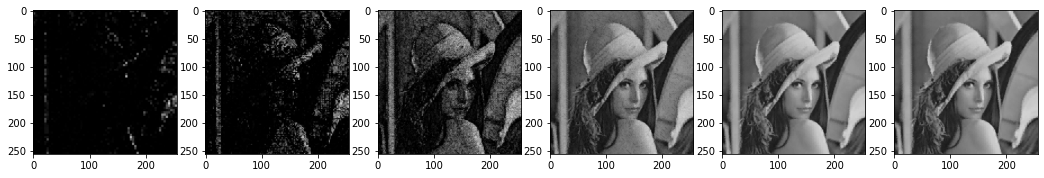

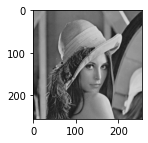

In [210]:
n_iters = [1, 2, 4, 8, 16, 32]

imgs = [comp.decompress(res, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray', vmin = 0, vmax = 255)

plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(lenna_gray_256x256, cmap ='gray', vmin = 0, vmax = 255)
plt.show()

In [ ]:
c = FractalCompressor()

h = FractalCompressionParams(256, 256, 0, 16, 10)
t = [BlockTransform(255, 4, ColorChange(0.75, 255), 7),
    BlockTransform(3, 4, ColorChange(0.75, 255), 7)]

b = c._ifs2buf(h, t)
print(b)

## Пробуем применить FractalCompressor

In [ ]:
comp = FractalCompressor()

In [ ]:
res = comp.compress(lenna_gray_256x256, block_size=8, stride=4)

Размер сжатого изображения в байтах == длина полученного массива `bytearray`

### Эволюция изображения при декомпрессии
Выглядит как увеличение фотографии в CSI: Место прреступления

In [ ]:
n_iters = [1, 2, 4, 8, 16]

imgs = [comp.decompress(res, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(lenna_gray_256x256, cmap ='gray')

### Поиграемся с параметрами сжатия
Понятно, что при увеличении перебора мы, во-первых, увеличиваем время вычислений, а во-вторых, улучшаем итоговое качество изображения после сжатия и декомпрессии.

Чтобы увеличить перебор можно уменьшить размер шага `stride` или уменьшить размер доменного блока `block_size`. Но не рекомендуется делать блок размером меньше 4х4.

In [ ]:
result_16x2 = comp.compress(lenna_gray_256x256, block_size=16, stride=2)

In [ ]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_16x2, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

In [ ]:
result_8x4 = comp.compress(lenna_gray_256x256, block_size=8, stride=4)

In [ ]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_8x4, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

In [ ]:
result_8x2 = comp.compress(lenna_gray_256x256, block_size=8, stride=2)

In [ ]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_8x2, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

## Построим график качества
Качество в данном случае будет измеряться по PSNR (а значит в децибелах).

Это базовый график для понимания соотношения между коэффициентом сжатия и качеством, получаемым на выходе. Можно посмотреть, как он будет меняться в зависимости от количества итераций при декомпрессии, например.

In [ ]:
def weighted_psnr(ref, img):
    assert ref.shape == img.shape, "Shape mismatch"
    if is_colored(img):
        ref_yuv = rgb2yuv(ref)
        img_yuv = rgb2yuv(img)
        
        return (4 * psnr(ref_yuv[..., 0], img_yuv[..., 0]) +
                    psnr(ref_yuv[..., 1], img_yuv[..., 1]) +
                    psnr(ref_yuv[..., 2], img_yuv[..., 2])
               ) / 6
    else:
        return psnr(ref, img)

In [ ]:
quality = [0, 20, 40, 60, 80, 100]

def test_image(img):
    compressed_images = [comp.compress2(img, quality=q) for q in quality]
    decompressed_images = [comp.decompress(compressed) for compressed in compressed_images]
    compression_rates = np.array([len(compressed) for compressed in compressed_images]) / img.size
    psnrs = [weighted_psnr(img, decompressed) for decompressed in decompressed_images]
    return compression_rates, psnrs

In [ ]:
def test_and_plot_collection(collection):
    _, ax = plt.subplots(figsize=(8, 6))

    for image in collection:
        compression_rates, psnrs = test_image(image)
        ax.plot(compression_rates, psnrs, marker='o', ms=10, ls='-.')

    ax.set_xlabel('Compression Rate', fontsize=16)
    ax.set_ylabel('PSNR, dB', fontsize=16)

    plt.show()

In [ ]:
test_and_plot_collection([lenna_gray_256x256])

In [ ]:
collection = []
for image_name in os.listdir('test_files'):
    image = resize(io.imread(os.path.join('test_files', image_name)), (256, 256))
    if is_colored(image):
        image = np.rint(rgb2gray(image) * 255).astype('uint8')
    collection.append(image)
test_and_plot_collection(collection)

## Улучшим алгоритм
Одним из основных способов улучшения сжатия изображений является разбиение картинки не на равные блоки, а на блоки разных размеров. Как дополнительную часть задания, мы предлагаем реализовать разбиение квадродеревом, это позволит более гибко настраивать параметры сжатия и получить лучшие результаты.

<center>Пример разбиения изображения на блоки с использованием квадродерева</center>

Исходное изображение | Разбиение квадродеревом
- | -
![Source image](images/house.jpg) | ![Segmentation](images/quadtree.jpg)

In [ ]:
import struct

value = np.float32(8.4)

def float_to_int(f):
    b = bytearray(struct.pack("e", value))
    x = int.from_bytes(b, byteorder = "big")
    return x
def int_to_float(i):
    b = int(i).to_bytes(2, byteorder = "big")
    f = struct.unpack("e", b)
    return f

a = BitBuffer()
a.push(float_to_int(value), 16)
print(int_to_float(a.pop(16)))


# print(*bytearray.__dict__, sep = "\n")

In [ ]:
def benchmark(iters):
    def actual_decorator(func):
        import time

        def wrapper(*args, **kwargs):
            total = 0
            for i in range(iters):
                start = time.time()
                return_value = func(*args, **kwargs)
                end = time.time()
                total = total + (end-start)
            return return_value, total / iters

        return wrapper
    return actual_decorator

iters = 1000
@benchmark(iters = iters)
def fun1(n):
    r = range(n)
    sum = 0
    for x in r:
        for y in r:
            sum += 1
    return sum

@benchmark(iters = iters)
def fun2(n):
    sum = 0
    for x, y in itertools.product(range(n), range(n)):
        sum += 1
    return sum

n = 10
print(fun3(n))

tot1 = tot2 = 0
exp = 10
for i in range(exp):
    tot1 += fun1(n)[1]
    tot2 += fun2(n)[1]
print(tot1 / exp, tot2 / exp)

In [ ]:
a = np.ones((4, 4))
b = np.array([[1, 2],
              [3, 4]])
c = np.multiply(a, np.kron(np.ones((2, 2)), b))
print(c)

In [ ]:
a = np.ones((2, 2))
print(a)